In [90]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

Feel free to experiment with different pool csv's. Beware: many rides means messy visualizations!

In [91]:
input_data = pd.read_csv("taxi_data_20190101_001500.csv",index_col=0)
interzonal_dist = pd.read_csv("interzonal.csv")

In [101]:
input_data.head()

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
0,6606,2019-01-01 00:15:49,2019-01-01 00:50:03,1,138,181
1,9596,2019-01-01 00:18:09,2019-01-01 00:41:11,1,161,138
2,1086,2019-01-01 00:19:03,2019-01-01 00:39:35,2,138,181
3,24,2019-01-01 00:19:55,2019-01-01 00:57:56,1,138,50


In [93]:
interzonal_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
0,0.0,46390.2,56813.2,34410.0,13834.9,13256.2,40598.2,41862.0,50006.8,46375.7,...,58781.9,34403.2,33748.3,23309.2,43392.1,60676.5,39255.3,29611.7,41990.4,42506.5
1,46340.8,0.0,33936.3,22108.1,49248.5,33819.3,28398.1,28693.7,21076.1,12127.1,...,36534.7,19707.0,19219.8,18987.1,8917.7,38555.3,18936.4,26857.9,26713.8,27229.9
2,58987.0,35229.4,0.0,25979.5,61894.8,46453.8,16981.5,16956.5,16807.1,25213.3,...,3008.8,28687.9,28788.4,36915.2,25550.7,5237.2,22664.8,29779.4,18016.7,18532.8
3,33650.0,22875.7,22646.4,0.0,36557.8,21116.8,10092.7,10824.1,21550.5,25507.6,...,24615.1,5426.0,3701.1,13404.1,14596.3,26509.7,10471.6,5806.3,7823.5,8339.6
4,12559.6,49367.0,59790.1,37386.8,0.0,14894.5,43575.1,44838.9,52983.7,49352.6,...,61758.8,37380.0,36725.2,26286.1,46369.0,63653.4,42232.2,32588.6,44967.2,45483.4


Considering only the rows for LaGuaradia as pick-up

In [94]:
input_data_filter = input_data[input_data['PULocationID'] == 138]

In [95]:
input_data_filter["Distance"] = input_data_filter.apply(lambda row: interzonal_dist.iloc[row["PULocationID"]-1, row["DOLocationID"]-1], axis=1)
input_data_filter

/home/harish/anaconda3/envs/adbms/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,Distance
0,6606,2019-01-01 00:15:49,2019-01-01 00:50:03,1,138,181,18452.4
2,1086,2019-01-01 00:19:03,2019-01-01 00:39:35,2,138,181,18452.4
3,24,2019-01-01 00:19:55,2019-01-01 00:57:56,1,138,50,13516.1


Setting ID column as index for faster operations

In [96]:
input_data_filter.set_index("id", drop=True, inplace=True)

Creating a directed graph and adding nodes to it. Each node is just the ID number of the ride

In [97]:
DG = nx.DiGraph()
index_list = input_data_filter.index.tolist()
DG.add_nodes_from(index_list)

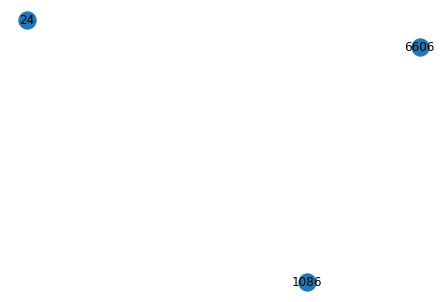

In [98]:
nx.draw(DG, with_labels=True)

The loop that adds edges and their corresponding weights to the graph. This is n^2.

In [99]:
for index1, index2 in combinations(index_list, 2):
    Da = input_data_filter.loc[index1, "Distance"]
    Db = input_data_filter.loc[index2, "Distance"]
    Dab = interzonal_dist.iloc[
        input_data_filter.loc[index1, "DOLocationID"]-1, 
        input_data_filter.loc[index2, "DOLocationID"]-1
    ]
    Dba = interzonal_dist.iloc[
        input_data_filter.loc[index2, "DOLocationID"]-1, 
        input_data_filter.loc[index1, "DOLocationID"]-1
    ]
    
    Dmin = min(Da + Dab, Db + Dba)
    distance_savings = Da + Db - Dmin
    weight = distance_savings / (Da + Db)
    DG.add_edge(index1, index2, weight=weight)

{(6606, 1086): Text(-0.31179541249164716, -0.4999999999999999, '0.5'),
 (6606,
  24): Text(0.39872496805521324, 0.22420909552314072, '0.1599167930932011'),
 (1086,
  24): Text(-0.08692955556356607, 0.2757909044768594, '0.1599167930932011')}

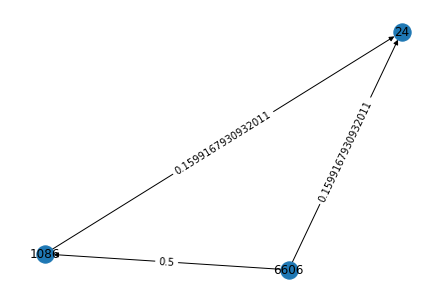

In [100]:
pos = nx.spring_layout(DG)
nx.draw(DG, pos, with_labels=True)
labels = nx.get_edge_attributes(DG,'weight')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels)

Both 1086 and 6606 are going to the same location, so the amount of distance saved is exactly 0.5. Does this make sense?